<a href="https://colab.research.google.com/github/minghsu0107/ML/blob/master/machine-learning/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Methods

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: *sequential* ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and *parallel* ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight.  The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging. 

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to *homogeneous ensembles*. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to *heterogeneous ensembles*. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.


## Bagging

Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:
\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.


In [0]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [0]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

(0, 0)
Accuracy: 0.63 (+/- 0.02) [Decision Tree]
(0, 1)
Accuracy: 0.70 (+/- 0.02) [K-NN]
(1, 0)
Accuracy: 0.66 (+/- 0.02) [Bagging Tree]
(1, 1)
Accuracy: 0.61 (+/- 0.02) [Bagging K-NN]


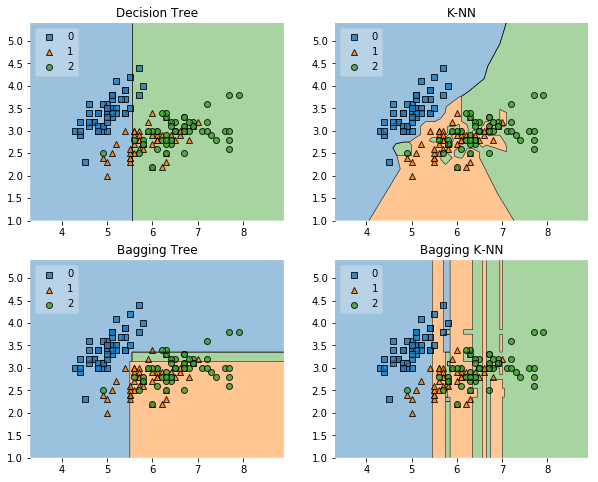

In [0]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2) #组合生成器,if repeat=3, then (0,0,0), (0,0,1), (0,1,0)... 2^3 possible answers

for clf, label, grd in zip(clf_list, label, grid):     
    print grd
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

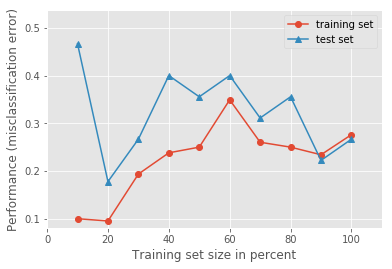

In [0]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of $0.3$ on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around $80\%$ of the training set size.

In [0]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

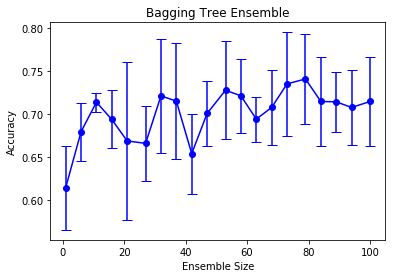

In [0]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $10$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $10$ only increases computational complexity without accuracy gains for the Iris dataset.

A commonly used class of ensemble algorithms are forests of randomized trees. In **random forests**, each tree in the ensemble is built from a sample drawn with replacement (i.e. a bootstrap sample) from the training set. In addition, instead of using all the features, a random subset of features is selected further randomizing the tree. As a result, the bias of the forest increases slightly but due to averaging of less correlated trees, its variance decreases resulting in an overall better model.

In **extremely randomized trees** algorithm randomness goes one step further: the splitting thresholds are randomized. Instead of looking for the most discriminative threshold, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

## Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.   

In [0]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [0]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
    
#XOR dataset
#X = np.random.randn(200, 2)
#y = np.array(map(int,np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)))
    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

Accuracy: 0.67 (+/- 0.00) [AdaBoost (n_est=1)]
Accuracy: 0.94 (+/- 0.04) [AdaBoost (n_est=2)]
Accuracy: 0.94 (+/- 0.04) [AdaBoost (n_est=3)]
Accuracy: 0.84 (+/- 0.09) [AdaBoost (n_est=10)]


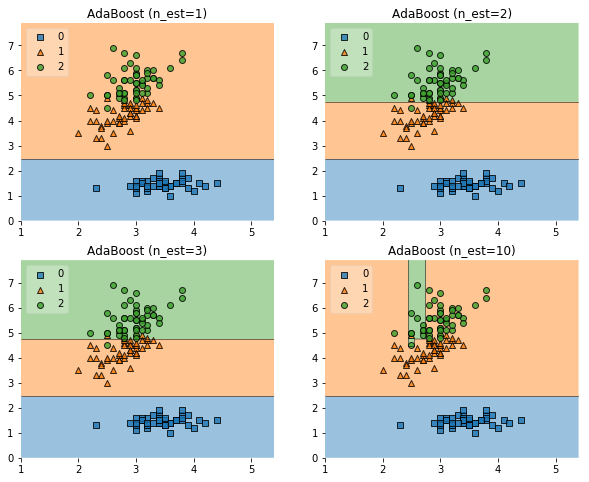

In [0]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    scores = cross_val_score(boosting, X, y, cv=3, scoring='accuracy')
    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
    
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

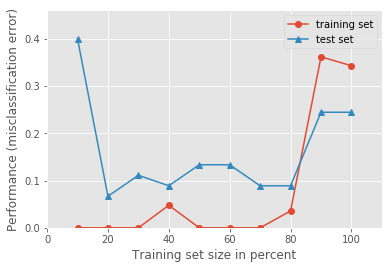

In [0]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [0]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

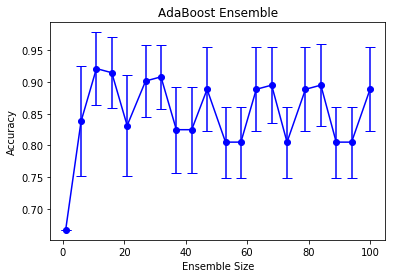

In [0]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble.

**Gradient Tree Boosting** is a generalization of boosting to arbitrary differentiable loss functions. It can be used for both regression and classification problems.

## Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [0]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [0]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

Accuracy: 0.91 (+/- 0.01) [KNN]


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]


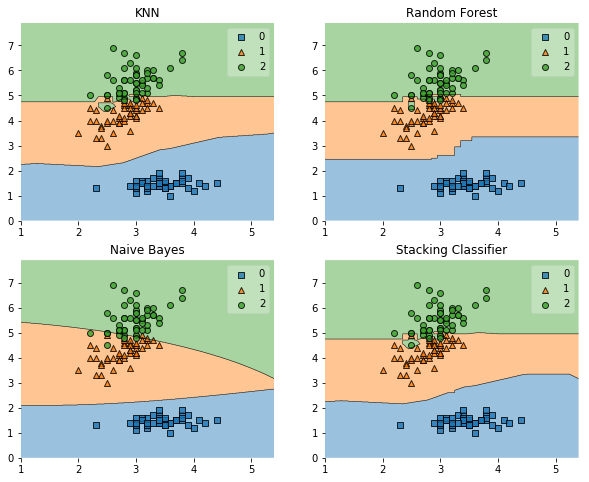

In [0]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

The stacking ensemble is illustrated int the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

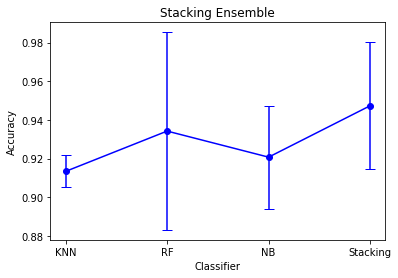

In [0]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

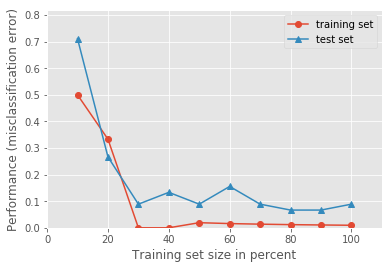

In [0]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

We can see that stacking achieves higher accuracy than individual classifiers and based on learning curves, it shows no signs of overfitting.

## Voting

In [0]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7329801777170198


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

ensemble.fit(X_train, y_train)

ensemble.score(X_test, y_test)

0.7748917748917749

0.9266666666666666
0.9933333333333333
0.96
0.9933333333333333


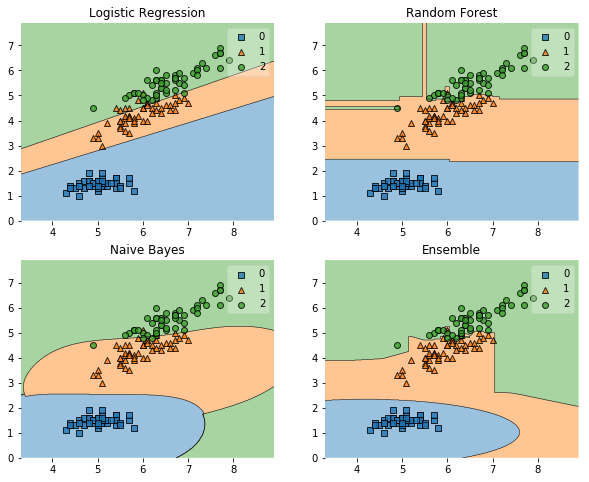

In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import itertools 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from mlxtend.classifier import EnsembleVoteClassifier 
from mlxtend.data import iris_data 
from mlxtend.plotting import plot_decision_regions 

# Initializing Classifiers 
clf1 = LogisticRegression(random_state=0) 
clf2 = RandomForestClassifier(random_state=0) 
clf3 = SVC(random_state=0, probability=True) 
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft') 

# Loading some example data 
X, y = iris_data() 
X = X[:,[0, 2]] 

label = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']
clf_list = [clf1, clf2, clf3, sclf]

# Plotting Decision Regions 
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)



for clf, lab, grd in zip(clf_list, label, grid):
    clf.fit(X, y)
    print(clf.score(X,y))
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

## More Voting

### Grid search

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft')

params = {'logisticregression__C': [1.0, 100.0],
          'randomforestclassifier__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(iris.data, iris.target)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))
print(grid.best_params_)
print(grid.best_score_)

0.953 +/- 0.01 {'randomforestclassifier__n_estimators': 20, 'logisticregression__C': 1.0}
0.960 +/- 0.01 {'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 1.0}
0.960 +/- 0.01 {'randomforestclassifier__n_estimators': 20, 'logisticregression__C': 100.0}
0.953 +/- 0.02 {'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 100.0}
{'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 1.0}
0.96


In [0]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf1, clf2], 
                              voting='soft')

params = {'logisticregression-1__C': [1.0, 100.0],
          'logisticregression-2__C': [1.0, 100.0],
          'randomforestclassifier__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

### Majority voting with classifiers trained on different feature subsets

we simply need to construct a Pipeline consisting of the feature selector and the classifier in order to select different feature subsets for different algorithms. During fitting, the optimal feature subsets are automatically determined via the GridSearchCV object, and by calling predict, the fitted feature selector in the pipeline only passes these columns along, which resulted in the best performance for the respective classifier.

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, :], iris.target

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

# Creating a feature-selection-classifier pipeline

sfs1 = SequentialFeatureSelector(clf1, 
                                 k_features=4,
                                 forward=True, 
                                 floating=False, 
                                 scoring='accuracy',
                                 verbose=0,
                                 cv=0)

clf1_pipe = Pipeline([('sfs', sfs1),
                      ('logreg', clf1)])

eclf = EnsembleVoteClassifier(clfs=[clf1_pipe, clf2, clf3], 
                              voting='soft')


params = {'pipeline__sfs__k_features': [1, 2, 3],
          'pipeline__logreg__C': [1.0, 100.0],
          'randomforestclassifier__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(iris.data, iris.target)



cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

0.953 +/- 0.01 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 20, 'pipeline__sfs__k_features': 1}
0.947 +/- 0.02 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 200, 'pipeline__sfs__k_features': 1}
0.953 +/- 0.01 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 20, 'pipeline__sfs__k_features': 2}
0.947 +/- 0.02 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 200, 'pipeline__sfs__k_features': 2}
0.953 +/- 0.01 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 20, 'pipeline__sfs__k_features': 3}
0.953 +/- 0.02 {'pipeline__logreg__C': 1.0, 'randomforestclassifier__n_estimators': 200, 'pipeline__sfs__k_features': 3}
0.947 +/- 0.02 {'pipeline__logreg__C': 100.0, 'randomforestclassifier__n_estimators': 20, 'pipeline__sfs__k_features': 1}
0.953 +/- 0.02 {'pipeline__logreg__C': 100.0, 'randomforestclassifier__n_estimators': 200, 'pipeline__sfs__k_features': 1}
0.947 +/- 0.02 {'pipeline__logre

In [0]:
grid.best_params_

{'pipeline__logreg__C': 100.0,
 'pipeline__sfs__k_features': 3,
 'randomforestclassifier__n_estimators': 20}

In [0]:
eclf = eclf.set_params(**grid.best_params_)
print(eclf.fit(X, y).predict(X[[1, 51, 149]]))
print(eclf.fit(X, y).predict_proba(X[[1, 51, 149]]))

[0 1 2]
[[9.21380916e-01 7.86190840e-02 5.73310207e-13]
 [1.90397960e-04 9.64638106e-01 3.51714960e-02]
 [3.72151919e-07 1.28700169e-01 8.71299459e-01]]


Alternatively, we can select different columns "manually" using the ColumnSelector object. In this example, we select only the first (sepal length) and third (petal length) column for the logistic regression classifier (clf1).

In [0]:
from mlxtend.feature_selection import ColumnSelector


col_sel = ColumnSelector(cols=[0, 2])

clf1_pipe = Pipeline([('sel', col_sel),
                      ('logreg', clf1)])

eclf = EnsembleVoteClassifier(clfs=[clf1_pipe, clf2, clf3],
                              voting='soft')
eclf.fit(X, y).predict(X[[1, 51, 149]])


array([0, 1, 2])

Furthermore, we can fit the SequentialFeatureSelector separately, outside the grid search hyperparameter optimization pipeline. Here, we determine the best features first, and then we construct a pipeline using these "fixed," best features as seed for the ColumnSelector:

In [0]:
sfs1 = SequentialFeatureSelector(clf1, 
                                 k_features=2,
                                 forward=True, 
                                 floating=False, 
                                 scoring='accuracy',
                                 verbose=1,
                                 cv=0)

sfs1.fit(X, y)

print('Best features', sfs1.k_feature_idx_)

col_sel = ColumnSelector(cols=sfs1.k_feature_idx_)

clf1_pipe = Pipeline([('sel', col_sel),
                      ('logreg', clf1)])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
Features: 1/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 2/2

('Best features', (0, 2))


In [0]:
eclf = EnsembleVoteClassifier(clfs=[clf1_pipe, clf2, clf3], 
                              voting='soft')
eclf.fit(X, y).predict(X[[1, 51, 149], :])

array([0, 1, 2])

### If desired, the different classifiers can be fit to different subsets of features in the training dataset. The following example illustrates how this can be done on a technical level using scikit-learn pipelines and the ColumnSelector:

In [0]:
from sklearn.datasets import load_iris
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

eclf = EnsembleVoteClassifier(clfs=[pipe1, pipe2])

eclf.fit(X, y)


EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(cols=(0, 2), drop_axis=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalt...nalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])],
            refit=True, verbose=0, voting='hard', weights=None)

## More Stacking

### Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting use_probas=True. If average_probas=True, the probabilities of the level-1 classifiers are averaged, if average_probas=False, the probabilities are stacked (recommended). For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

    classifier 1: [0.2, 0.5, 0.3]
    classifier 2: [0.3, 0.4, 0.4]

If average_probas=True, the meta-features would be:

    [0.25, 0.45, 0.35]

In contrast, using average_probas=False results in k features where, k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

    [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]


In [3]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=True,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))


3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.04) [StackingClassifier]


### Stacked Classification and GridSearch

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.667 +/- 0.00 {'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.667 +/- 0.00 {'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.927 +/- 0.02 {'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.920 +/- 0.03 {'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.667 +/- 0.00 {'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.667 +/- 0.00 {'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 5}
0.933 +/- 0.02 {'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.940 +/- 0.02 {'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifie

In [5]:
sclf = sclf.set_params(**grid.best_params_)
print(sclf.fit(X, y).predict(X[[1, 51, 149]]))
print(sclf.fit(X, y).predict_proba(X[[1, 51, 149]]))

[0 1 2]
[[7.66002959e-01 2.33832527e-01 1.64513588e-04]
 [1.64098237e-02 8.30956363e-01 1.52633813e-01]
 [4.96980005e-07 2.81221350e-01 7.18778153e-01]]


### StackingCVClassifier

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [0]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

In [31]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))


3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.04) [StackingClassifier]


In [33]:
print(sclf.fit(X, y).predict(X[[1, 51, 149]]))
print(sclf.fit(X, y).predict_proba(X[[1, 51, 149]]))

[0 1 2]
[[0.95861407 0.02043965 0.02094628]
 [0.02072569 0.87911246 0.10016186]
 [0.02015608 0.12758838 0.85225555]]


In [34]:
sclf.predict_meta_features(X)

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.00000000e+000, 1.90107884e-010, 2.97764271e-014],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.99999996e-001, 4.30128334e-009, 2.16956623e-013],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.99999999e-001, 5.18574883e-010, 3.80087293e-014],
       ...,
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        3.34792633e-103, 1.28234113e-001, 8.71765887e-001],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        7.76400282e-114, 1.90371773e-002, 9.80962823e-001],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        9.19861016e-098, 2.02504719e-001, 7.97495281e-001]])